In [1]:
# 2020.02.18 ...
# data analysis for ground anchors
# for ASTRA Thun

# description of anchor data analysis task

<br /> 
<br /> 
<br /> 
<br /> 
<br /> 


# setup

In [2]:
# setup for python ecosystem
import json
from math import *
import glob
import pandas as pd
import numpy as np
from IPython.core.display import HTML, display
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import norm
from scipy.stats import lognorm
from scipy import stats

In [3]:
# setup for pandas
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns',100)

In [4]:
# setup for pixiedust data exploration
import pixiedust
from pixiedust.display import *
# installed:
# sudo pip install --user --upgrade pixiedust 
# sudo pip install seaborn
# sudo pip install bokeh

# "Bad 'legend' parameter value: None" when plotting bokeh with pixiedust
# https://github.com/org-arl/arlpy/issues/31 
# appears to be bug with bokeh, fix is to degrade the version of Bokeh 1.3
# sudo pip install bokeh==1.3.0

Pixiedust database opened successfully


In [5]:
# define common functions

# function for calculating allowable anchor force
# based on SIA 260 (2013) 
# as documented in https://docs.google.com/spreadsheets/d/17GsuXH_9kubzu-f16cIugCzPtyKBbbA4Jdm00d-uyHU/edit#gid=469557799
#   steel_xsect_area = total steel cross-section, e.g. of steel tendon strands (mm)
#   steel_tensile_strength_char = characteristic tensile strength of anchor steel (N/mm2 = MPa)
#   anchor_load_char = anchor load when characteristic tensile strength of anchor steel is reached (kN)
def anchor_load_char_calc_sia260(steel_xsect_area, steel_tensile_strength_char):
    anchor_load_char = steel_xsect_area * steel_tensile_strength_char /1000.0
    return(anchor_load_char)

# function for determining capacity utilization of an anchor
# based on ASTRA "Risikoanalyse"  
# as documented in https://docs.google.com/spreadsheets/d/17GsuXH_9kubzu-f16cIugCzPtyKBbbA4Jdm00d-uyHU/edit#gid=4695577997
#   measured_anchor_load = measured anchor load during monitoring (kN)
#   measurement_tol = measurement tolerance (%)
#   anchor_capacity_utiliz = pro cent capacity utilization of an anchor (fraction between 0 and 1)
def anchor_capacity_utiliz_calc_astra(measured_anchor_load, measurement_tol, anchor_load_char):
    anchor_capacity_utiliz = measured_anchor_load * (1-measurement_tol/100) / anchor_load_char
    return(anchor_capacity_utiliz) 

# function for calculating change in anchor load to installed anchor load 
# based on ASTRA "Risikoanalyse"  
#   installed_anchor_load = anchor load at time of anchor installation (kN)
#   anchor_load_change = measured anchor load minus installed anchor load (kN, positive value means increase load)
def anchor_load_change_calc_astra(measured_anchor_load, installed_anchor_load):
    anchor_load_change = measured_anchor_load - installed_anchor_load
    return(anchor_load_change)


# TEMP WORK
# function for .... error bars ...
def error_bar_calc(installed_anchor_load):
    error_bars = 0.2 * installed_anchor_load
    return(error_bars)


# remarks on input data

* data sources
  * https://drive.google.com/drive/folders/1hg8eD9MrwUcdzMDHcKWOA0V6jrQybA9j
  * spreadshhets for five example structures
    * SM 4
    * SM 1 + B18
    * Felssicherung Chüebalm
    * Brücke Tuffgraben
    * SM 5


* the data in the sources cited above were taken by Tosacano AF 
  from various reports and drawings made available from ASTRA; <br /> 
  in this data analysis only data from the above five data sources are consdered


* data in data sources is partly conflicted in other documents
    * SM 4 in spreadsheet 'Untersuchung_Ankerkräfte_Risk  SM4' <br /> 
      https://docs.google.com/spreadsheets/d/17GsuXH_9kubzu-f16cIugCzPtyKBbbA4Jdm00d-uyHU/edit#gid=1364999228 <br /> 
      --> differences in steel area and steel strength


* structure_id and anchor_id
  * decimals (and spaces) in IDs are bad data practice


* data from the spreadsheets was prepared by linking the original data in each spreadsheet to a CSV worksheet in the same worksheet, <br /> using common headers agreed specifically for this work, and then exporting the CSV worksheet


* the data from the intial anchor measurements (labelled P0 in the source spreadsheets) is enetered both as   installed_anchor_load and measured_anchor_load data; <br /> 
 this foresees that the two data sets may difer, e.g. installed_anchor_load may correspond to the intial prescribed load ("Festsetzkraft") and the measured_anchor_load may correspond to the actual installed anchor load (which may differ from the prescribe load if within a specified tolerance)


* the data entry sheet, the CSV sheet and the data column headers require additional review and refinement <br /> 
  before the collection and preparation of additional anchor data (see also remarks to data table design below)


# remarks to flat table from CSV sheet in spreadsheet:

* the CSV sheet for anchor data is configured as a single flat table <br />
  using a common header line with header titles for each data column
* the data structure suggests that two separate tables (anchor data table, measurment data table) should be used, <br />
  which would e.g. avoid the repetition of anchor data for each measurment record
* the anchor data table and measurment data table would then be joined in pandas into a single table
* a single flat table is used in this preliminary proof-of-concept work to simplify data preparation
* an appropriate data table design, e.g. using separate anchor data tables and measurment data tables <br /> 
  should be completed before additional input data is prepared
* a separate data entry sheet in the spreadsheet should be designed together with the data table design; <br /> 
  the purpose of the data entry sheet is to make data entry as easy and error free as possible, <br />
  with the CSV sheet being configured separately and structured for data analysis
  
  
* the first header line is intended for accessing data from python code and is in English using snake_case    
* a second header line is in German text and is intended to be used for figure and table titles
* additional header lines could be added for other languages


* additional data tables to consider are
  * structures table <br /> 
    using an appropriate structures id as a database key
  * anchor type table (?) <br /> 
    considering however that this will complicate data entry and whether anchor detail data is required

# data input

In [6]:
# read in csv files containign anchor data
anchors_df = pd.concat([pd.read_csv(f, header=[0,1], encoding='utf-8') for f in glob.glob('data/ASTRA/*.csv')], 
                       ignore_index = True)

# remove second header line (for this work)
anchors_df.columns = anchors_df.columns.droplevel(-1)

#glob.glob('data/ASTRA/*.csv')  #testing
#anchors_df.dtypes  #testing

# data analysis

In [7]:
# calculated fields

anchors_df["anchor_load_char"] = anchor_load_char_calc_sia260(anchors_df.steel_xsect_area, 
                                                anchors_df.steel_tensile_strength_char)

measurement_tol = 2.5  # %
anchors_df["anchor_capacity_utiliz"] = anchor_capacity_utiliz_calc_astra(anchors_df.measured_anchor_load, 
                                                measurement_tol, anchors_df.anchor_load_char)

anchors_df["anchor_load_change"] = anchor_load_change_calc_astra(anchors_df.measured_anchor_load, 
                                                anchors_df.installed_anchor_load)


# TEMP WORK
anchors_df["error_bars"] = error_bar_calc(anchors_df.installed_anchor_load)

In [8]:
#anchors_df[anchors_df.anchor_id.isin(['9a','9b'])]
#anchors_df[anchors_df.structure_id.isin(['SM4'])]
anchors_SM4 = anchors_df[anchors_df.structure_id.isin(['SM4'])]
anchors_SM1 = anchors_df[anchors_df.structure_id.isin(['SM1'])]

# testing

In [9]:
# configure date columns
#   dates in original data and csv data are year only
#   year date yyyy will be presumed as yyyy/01/01



In [10]:
# data validity checking
#   test suite for testing data validity checking 
#   (e.g. string instead of float value, blank lines in csv data, garbled header title, ID fields NaN)

# how to introduce plausibility checking for measurement data?
#   simply omitting out-of-range values is not good, as anchors can conceivably fail e.g. leading to low measured values
#   maybe warning message and a function to manually delete a value, adding a comment to a new comment field?

# how to introduce plausibility checking for calculated data?
#   e.g if suspect capacity utilization in initial measurement


In [11]:
# function testing

steel_xsect_area = 1116  # mm2
steel_tensile_strength_char = 1770  # MPa
anchor_load_char = anchor_load_char_calc_sia260(steel_xsect_area, steel_tensile_strength_char)
print(anchor_load_char)

measured_anchor_load = 1100.0  #kN
measurement_tol = 2.5  # %
anchor_capacity_utiliz = anchor_capacity_utiliz_calc_astra(measured_anchor_load, measurement_tol, anchor_load_char)
print(anchor_capacity_utiliz)

installed_anchor_load = 1000.0
anchor_load_change = anchor_load_change_calc_astra(measured_anchor_load, installed_anchor_load)
print(anchor_load_change)

1975.32
0.542950003037
100.0


In [12]:
# end-to-end testing
anchors_SM4[anchors_df['measurement_date']==2019].describe()
#anchors_SM4[anchors_df['measurement_date']==2019].sum()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,anchor_type,steel_tensile_strength_char,steel_xsect_area,anchor_load_char_calculation_method,anchor_load_char,warning_value_calculation_method,alarm_value_calculation_method,warning_value,alarm_value,installation_date,installed_anchor_load,measurement_date,measured_anchor_load,anchor_capacity_utiliz,anchor_load_change,error_bars
count,0.0,28.0,28.0,0.0,28.00,0.0,0.0,0.0,0.0,20.0,20.000000,28.0,28.000000,28.000000,20.000000,20.000000
mean,NaN,1770.0,1116.0,NaN,1975.32,NaN,NaN,NaN,NaN,1984.0,960.000000,2019.0,995.750000,0.491493,31.350000,192.000000
std,NaN,0.0,0.0,NaN,0.00,NaN,NaN,NaN,NaN,0.0,104.629673,0.0,90.342404,0.044592,30.014514,20.925935
min,NaN,1770.0,1116.0,NaN,1975.32,NaN,NaN,NaN,NaN,1984.0,600.000000,2019.0,620.000000,0.306026,-24.000000,120.000000
25%,NaN,1770.0,1116.0,NaN,1975.32,NaN,NaN,NaN,NaN,1984.0,1000.000000,2019.0,992.000000,0.489642,14.250000,200.000000
50%,NaN,1770.0,1116.0,NaN,1975.32,NaN,NaN,NaN,NaN,1984.0,1000.000000,2019.0,1013.500000,0.500254,40.000000,200.000000
75%,NaN,1770.0,1116.0,NaN,1975.32,NaN,NaN,NaN,NaN,1984.0,1000.000000,2019.0,1044.250000,0.515432,48.250000,200.000000
max,NaN,1770.0,1116.0,NaN,1975.32,NaN,NaN,NaN,NaN,1984.0,1000.000000,2019.0,1091.000000,0.538508,91.000000,200.000000


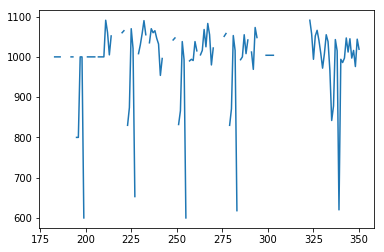

In [13]:
# check handling of NaN values by pandas plot -> NaN values are omitted in plot
# plot of anchor loads vs index    
#anchors_SM4.measured_anchor_load
anchors_SM4.measured_anchor_load.plot()

# dataframe views

In [14]:
anchors_df
#anchors_df[anchors_df['structure_id']=='SM1']
#anchors_df[anchors_df['anchor_id']=='18b']

,structure_id,structure_name,structure_type,anchor_id,anchor_type,steel_tensile_strength_char,steel_xsect_area,anchor_load_char_calculation_method,anchor_load_char,warning_value_calculation_method,alarm_value_calculation_method,warning_value,alarm_value,installation_date,installed_anchor_load,measurement_date,measured_anchor_load,stress_unit,force_unit,area_unit,anchor_capacity_utiliz,anchor_load_change,error_bars
0,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,101,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2003,1000.0,MPa,kN,mm,0.500770,0.0,200.0
1,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,102,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2003,1000.0,MPa,kN,mm,0.500770,0.0,200.0
2,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,103,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2003,1000.0,MPa,kN,mm,0.500770,0.0,200.0
3,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,104,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2003,1000.0,MPa,kN,mm,0.500770,0.0,200.0
4,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,105,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2003,1000.0,MPa,kN,mm,0.500770,0.0,200.0
5,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,106,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2003,1000.0,MPa,kN,mm,0.500770,0.0,200.0
6,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,107,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2003,1000.0,MPa,kN,mm,0.500770,0.0,200.0
7,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,101,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2010,1120.0,MPa,kN,mm,0.560863,120.0,200.0
8,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,102,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2010,1105.0,MPa,kN,mm,0.553351,105.0,200.0
9,Felssicherung Chuebalm,Chüebalmtunnel Westportal,Tunnelportal,103,NaN,1770.0,1100.0,NaN,1947.00,NaN,NaN,NaN,NaN,2003.0,1000.0,2010,1130.0,MPa,kN,mm,0.565871,130.0,200.0


In [15]:
anchors_SM1


,structure_id,structure_name,structure_type,anchor_id,anchor_type,steel_tensile_strength_char,steel_xsect_area,anchor_load_char_calculation_method,anchor_load_char,warning_value_calculation_method,alarm_value_calculation_method,warning_value,alarm_value,installation_date,installed_anchor_load,measurement_date,measured_anchor_load,stress_unit,force_unit,area_unit,anchor_capacity_utiliz,anchor_load_change,error_bars
351,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",NaN,24.1a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
352,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,24.1b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
353,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,20.a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
354,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,20.b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
355,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,19.a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
356,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,19.b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
357,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,18.a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
358,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,18.b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
359,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,17.a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0
360,SM1,"N8, Bönigen-Iseltwald, Sm 1 und B18",Stützmauer,17.b,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1983.0,1000.0,1983,1000.0,MPa,kN,mm,NaN,0.0,200.0


# data plots
### "... tell the (data) story"


### data overview

In [ ]:
# basic data check of all measured anchor loads
display(anchors_df)

# anchor 4B in SM5 for 1994 measurment appears invalid!


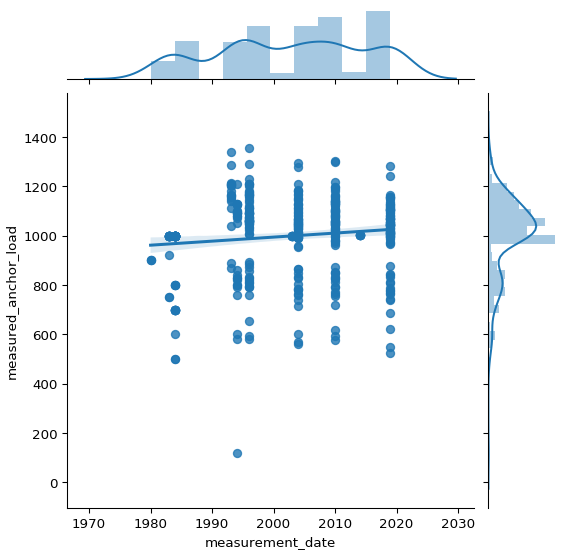

In [ ]:
# basic data check of all anchor measurements over time
display(anchors_df)

### data trends

In [ ]:
# scatterplot of anchor capacity utilization vs anchor load change
display(anchors_df)

# careful: anchor_id's are not unique !!
# anchor 18c at SMC4 has low capacity utilization, is data for calc_anchor_load correct ??

In [ ]:
# average of all anchors at each strcuture
display(anchors_df)

#display(anchors_SM1)
#display(anchors_df[anchors_df.structure_id.isin(['Bruecke Tuffgraben'])])
#display(anchors_SM4)

# are NaN values taken as zero??
# e.g. SM1 is not displayed correctly with 'display(anchors_df)', compare with 'display(anchors_SM1)'
#   -> looks more like a bug with pixiedust

### data for indiviudal anchors

In [ ]:
# anchor load over time for individual anchors
display(anchors_df[anchors_df['anchor_id']=='18b'])

# careful: anchor_id's are not unique !!
#          and 18.b and 18.b give same result !!  -> seems to be strange pixiedust behvaior
#            decimals (and spaces) in IDs are bad practice !!
# NaN values are omitted (expected behavior), but why different further below in subplots ??

In [ ]:
# anchor load over time for all individual anchors at a structure
#display(anchors_SM4)
display(anchors_SM1)
#display(anchors_df[anchors_df.structure_id.isin(['Bruecke Tuffgraben'])])

# NaN values taken as zero if Aggregation -> SUM used
# NaN values omitted if Aggregation -> AVG used

In [22]:
# TEMP WORK

/usr/local/lib/python2.7/dist-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


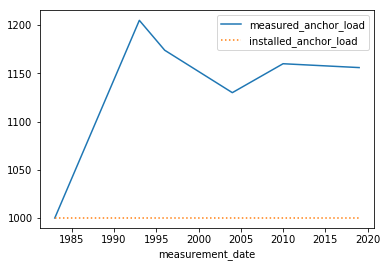

In [23]:
####fig = plt.figure()

#anchors_df[anchors_df['anchor_id']=='18.b'].measured_anchor_load.plot

anchors_df[anchors_df['anchor_id']=='18.b'].plot(x='measurement_date', 
                                                 y=['measured_anchor_load','installed_anchor_load'], 
                                                 style=['-',':'])

#anchors_df[anchors_df['anchor_id']=='18.b'].plot(x='measurement_date', 
#                                                 y=['measured_anchor_load'], 
#                                                 style=['-'])

#anchors_df[anchors_df['anchor_id']=='18.b'].plot(x='measurement_date', 
#                                                 y=['measured_anchor_load','installed_anchor_load'],
#                                                 style=['-',':'], yerr='error_bars')

#anchors_df[anchors_df['anchor_id']=='18.b'].plot(x='measurement_date', 
#                                                 y=['installed_anchor_load'],
#                                                 style=[':'], yerr='error_bars')

####plt.show()